## Data Preparation: Calculate regional LV strain from cine CMR

You should prepare two things before running this step. Please refer to the `example_data` folder for guidance:

1. **NIfTI images** of cine CMR and **corresponding segmentation**
   - Please re-organize your data so that each time frame (3D volume) is a separate nii file. 
   - The segmentations were done by our [cineCMR segmentation foundation model](https://github.com/zhennongchen/cineCMR_SAM), or you can prepare by your own.
   - make sure your image/segmentation numpy array start from ***basal slice***.

2. **A patient list** that enumerates all your cases.  
   - To understand the expected format, please refer to the file:  
     `example_data/Patient_lists/patient_list.xlsx`.

3. **A clinical data list** that record the clinical data (from electronic health record).  
   - only need it if you want to add clinical data into model input in step 2.

4. **Download Deepstrain weights** from [source](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/XB6PEZ ) to your local
   - download carmen_Jan2021.h5 and carson_Jan2021.h5


---

## Get regional LV strain from cine CMR

In this script we use published method [DeepStrain](https://github.com/moralesq/DeepStrain) to generate regional LV strain from cine CMR short-axis (SAX) views. we use the first time frame (end-diastole) as template.

---

### Docker environment
Please use `docker/docker_tensorflow`, it will build a tensorflow docker


In [2]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

from tensorflow.keras.optimizers import Adam
from models import deep_strain_model
from utils import myocardial_strain_zc
from scipy.ndimage import gaussian_filter

import HFpEF_CMR_GraphStrain.functions_collection as ff


main_path = '/mnt/camca_NAS/Deepstrain'

### Section 1: get motion vector field using DeepStrain

please download weights from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/XB6PEZ 

In [4]:
# define model
class Options():
    
    def __init__(self):
        
        self.datadir = os.path.join(main_path,'data/')
        self.isTrain = False
        self.volume_shape = (128,128,16,1) # in network the input shape is [None, 128, 128, 16,2]
        self.pretrained_models_netS  = os.path.join(main_path,'models/trained/carson_Jan2021.h5')  # change to your own path
        self.pretrained_models_netME = os.path.join(main_path,'models/trained/carmen_Jan2021.h5')  # change to your own path

        
opt = Options()

model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

In [6]:
# define the patient list 
patient_list = pd.read_excel(os.path.join(main_path, 'example_data/Patient_list/patient_list.xlsx'))
patient_list = patient_list[patient_list['include?'] == 'yes']
print(patient_list.shape)

(1, 4)


In [9]:
# get motion vector field from CMR
for i in range(0, patient_list.shape[0]):
    patient_num = patient_list['OurID'].iloc[i]
    patient_id = ff.XX_to_ID_00XX(patient_num)

    print(patient_id)

    # save folder
    save_folder = os.path.join(main_path, 'example_data/results/MVF', patient_id)
    ff.make_folder([os.path.join(main_path,'example_data/results'), os.path.join(main_path,'example_data/results/MVF'), save_folder])

    # define data folders
    patient_img_folder = os.path.join(main_path,'example_data/raw_nii_images',patient_id, 'img') 
    patient_seg_folder = os.path.join(main_path,'example_data/raw_nii_images',patient_id, 'seg')

    # define template tf and target tf
    template_tf = 0

   
    for target_tf in range(0,15):
        print('current time frame pairs: ', template_tf, target_tf)

        # load data
        V_nifti_1 = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(template_tf) + '.nii.gz'))
        V_nifti_2 = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(target_tf) + '.nii.gz'))     

        M_nifti_1 = nb.load(os.path.join(patient_seg_folder, 'seg_tf' + str(template_tf) + '.nii.gz'))
        M_nifti_2 = nb.load(os.path.join(patient_seg_folder ,'seg_Tf' + str(target_tf) + '.nii.gz'))


        ##########################
        # # preprocess our data and save it for future use!
        V_nifti = nb.funcs.concat_images((V_nifti_1, V_nifti_2))
        M_nifti = nb.funcs.concat_images((M_nifti_1, M_nifti_2))

        # data was trained with:
        #  in-plane resolution of 1.25 mm x 1.25 mm
        #  number of slices = 16
        #  variable slice thickness since we specify number of slices
        V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
        M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)
        

        # calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
        center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2) 
        V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
        M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)

        # save preprocessed image
        preprocessed_input_folder = os.path.join(main_path, 'example_data/results/preprocessed_inputs', patient_id)
        ff.make_folder([preprocessed_input_folder, os.path.join(preprocessed_input_folder, 'img'), os.path.join(preprocessed_input_folder, 'seg'), os.path.join(preprocessed_input_folder, 'img_cropped'), os.path.join(preprocessed_input_folder, 'seg_cropped')])
        nb.save(nb.Nifti1Image(V_nifti.get_fdata()[:,:,:,1], affine=V_nifti.affine, header=V_nifti.header), os.path.join(preprocessed_input_folder, 'img/img_tf' + str(target_tf) + '.nii.gz'))
        nb.save(nb.Nifti1Image(M_nifti.get_fdata()[:,:,:,1], affine=M_nifti.affine, header=M_nifti.header), os.path.join(preprocessed_input_folder, 'seg/seg_tf' + str(target_tf) + '.nii.gz'))
        nb.save(nb.Nifti1Image(V[:,:,:,1], affine=V_nifti.affine, header=V_nifti.header), os.path.join(preprocessed_input_folder, 'img_cropped/img_tf' + str(target_tf) + '.nii.gz'))
        nb.save(nb.Nifti1Image(M[:,:,:,1], affine=M_nifti.affine, header=M_nifti.header), os.path.join(preprocessed_input_folder, 'seg_cropped/seg_tf' + str(target_tf) + '.nii.gz'))

        ##########################
        # # Get motion vector field
        V = ff.normalize_image(V)
        nx, ny, nz, nt = V.shape
        V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
        V_t =  V[:,:,:,1:]

        V_0 = np.transpose(V_0, (3,0,1,2))
        V_t = np.transpose(V_t, (3,0,1,2))

        # predict motion vector
        y_t = netME([V_0, V_t]).numpy()
        y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

        # save
        a = nb.Nifti1Image(y_t[0,:,:,:,:] , affine=V_nifti.affine, header=V_nifti.header)
        filename =  'mvf_template' + str(template_tf) + '_target'+ str(target_tf) + '.nii.gz'
        nb.save(a, os.path.join(save_folder, filename))

ID_0287
current time frame pairs:  0 0


2025-06-30 16:11:42.688999: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2025-06-30 16:11:49.660920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2025-06-30 16:11:51.213079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2025-06-30 16:11:52.291738: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


current time frame pairs:  0 1
current time frame pairs:  0 2
current time frame pairs:  0 3
current time frame pairs:  0 4
current time frame pairs:  0 5
current time frame pairs:  0 6
current time frame pairs:  0 7
current time frame pairs:  0 8
current time frame pairs:  0 9
current time frame pairs:  0 10
current time frame pairs:  0 11
current time frame pairs:  0 12
current time frame pairs:  0 13
current time frame pairs:  0 14


### Section 2: Manully annotate RV insertion point for AHA segments
the regional LV strain is reported per-AHA-segment. Therefore we need to define the insertion point so that we can rotate the image properly.

you can do it using your own automatic algorithm, or do it one by one manually (it won't take much time)

In [2]:
# define a patient
patient_list = pd.read_excel(os.path.join(main_path, 'example_data/Patient_list/patient_list.xlsx'))
patient_list = patient_list[patient_list['include?'] == 'yes']
patient_index = 0

patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
print(patient_id)

ID_0287


mid_slice:  8
already defined
insertion_p1:  [40 65]  insertion_p2:  [65 43]


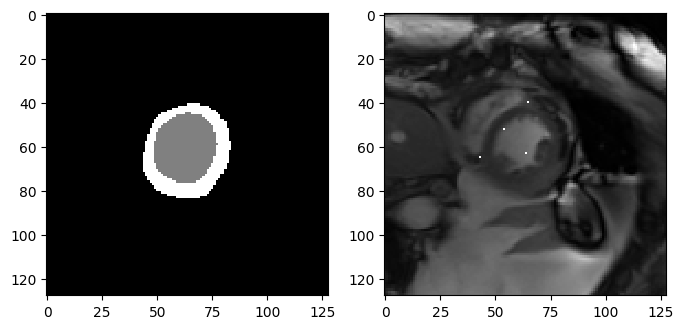

In [12]:
patient_img_folder = os.path.join(main_path,'example_data/results/preprocessed_inputs',patient_id, 'img_cropped')
patient_seg_folder = os.path.join(main_path,'example_data/results/preprocessed_inputs',patient_id, 'seg_cropped')
img_ed = nb.load(os.path.join(patient_img_folder, 'img_tf0.nii.gz')).get_fdata()
mask_ed = nb.load(os.path.join(patient_seg_folder, 'seg_tf0.nii.gz')).get_fdata()

y_t = nb.load(os.path.join(main_path, 'results/MVF', patient_id, 'mvf_template0_target1.nii.gz')).get_fdata()
y_t = y_t[None,...]

strain = myocardial_strain_zc.MyocardialStrain(mask=mask_ed, flow=y_t[0,:,:,:,:])

save_folder = os.path.join(main_path, 'example_data/results/strain/', patient_id)
ff.make_folder([os.path.join(main_path,'example_data/results'), os.path.join(main_path,'example_data/results/strain'), save_folder])

# define the effective slices
effective_slices_list = []
for i in range(0,15):
    patient_seg_folder = os.path.join(main_path,'example_data/results/preprocessed_inputs',patient_id, 'seg')
    patient_seg = nb.load(os.path.join(patient_seg_folder, 'seg_tf' + str(i) + '.nii.gz')).get_fdata()
    effective_slice = []
    for j in range(patient_seg.shape[2]):
        if np.sum(patient_seg[:,:,j]==2)>0: 
            effective_slice.append(j)
    effective_slices_list.append(effective_slice)

sets = [set(lst) for lst in effective_slices_list]
intersection = set.intersection(*sets)
effective_slices = list(intersection)

# define mid slice
mid_slice = effective_slices[len(effective_slices)//2]
print('mid_slice: ', mid_slice)

# define the RV insertion point
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(strain.mask[:,:,mid_slice], cmap='gray')
if os.path.isfile(os.path.join(save_folder, 'insertion_points.npy')):
    print('already defined')
    insertion_points = np.load(os.path.join(save_folder, 'insertion_points.npy'))
    insertion_p1 = insertion_points[0,:]
    insertion_p2 = insertion_points[1,:]
    print('insertion_p1: ', insertion_p1, ' insertion_p2: ', insertion_p2)
else:
    print('no there should be pre-defined insertion points!, please define them manully by changing the code below. you will see the points in the figure')
    # from the figure, we define the RV insertion points
    insertion_p1 = [40,65]
    insertion_p2 = [65,43]
    # make insertion_p1 and p2 as a 2x2 numpy array
    insertion_points = np.vstack((np.asarray(insertion_p1), np.asarray(insertion_p2)))
    np.save(os.path.join(save_folder, 'insertion_points.npy'), insertion_points)

# get the rotation angle ready
phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(strain.mask, insertion_p1, insertion_p2)

# plot
ii = np.copy(img_ed[:,:,mid_slice])
ii[insertion_p1[0], insertion_p1[1]] = np.max(ii); ii[insertion_p2[0], insertion_p2[1]] = np.max(ii)
ii[int(cx_lv), int(cy_lv)] = np.max(ii); ii[int(cx_rv), int(cy_rv)] = np.max(ii)
plt.subplot(122); plt.imshow(ii, cmap='gray')


### Section 3: Get global and regional LV strain
make sure you have motion vector fields and RV insertion points ready.

The product is Ecc_aha/Err_aha which is a 17-length vector which includes strain for 16 segments + strain for apex (always set to 0, not used)

The results including global strains and regional strains will be saved as a numpy file for each time frame.

In [13]:
patient_list = pd.read_excel(os.path.join(main_path, 'example_data/Patient_list/patient_list.xlsx'))
patient_list = patient_list[patient_list['include?'] == 'yes']

In [18]:
save_folder = os.path.join(main_path, 'example_data/results/strain/')

for i in range(patient_list.shape[0]):
    patient_id_num = patient_list['OurID'].iloc[i]
    patient_id = ff.XX_to_ID_00XX(patient_id_num)
 
    print(i,patient_id)
    patient_save_folder = os.path.join(save_folder, patient_id)

    # define the effective slices
    effective_slices_list = []
    for i in range(0,15):
        patient_seg_folder = os.path.join(main_path,'example_data/results/preprocessed_inputs',patient_id, 'seg')
        patient_seg = nb.load(os.path.join(patient_seg_folder, 'seg_tf' + str(i) + '.nii.gz')).get_fdata()
        effective_slice = []
        for j in range(patient_seg.shape[2]):
            if np.sum(patient_seg[:,:,j]==2)>0:
                effective_slice.append(j)
        effective_slices_list.append(effective_slice)

    sets = [set(lst) for lst in effective_slices_list]
    intersection = set.intersection(*sets)
    effective_slices = list(intersection)

    # get the layer info
    slices_per_layer = len(effective_slices)//3
    mod = len(effective_slices)%3
    if mod == 1 or mod == 2:
        mod = 1

    apex_layer = effective_slices[len(effective_slices) - slices_per_layer : len(effective_slices)]
    mid_layer = effective_slices[len(effective_slices) - slices_per_layer * 2 -mod : len(effective_slices) - slices_per_layer]
    base_layer = effective_slices[0: len(effective_slices) - slices_per_layer * 2 -mod]
    mid_slice = effective_slices[len(effective_slices)//2]

    template_tf = 0

    for target_tf in range(0,15):
        tf1 = template_tf
        tf2 = target_tf

        patient_save_folder_timeframe = os.path.join(patient_save_folder, 'tf_' + str(tf2))
        ff.make_folder([patient_save_folder_timeframe])

        # load img and seg
        patient_img_folder = os.path.join(main_path,'example_data/results/preprocessed_inputs',patient_id, 'img_cropped')
        patient_seg_folder = os.path.join(main_path,'example_data/results/preprocessed_inputs',patient_id, 'seg_cropped')

        V_nifti_1 = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(tf1) + '.nii.gz'))
        V_nifti_2 = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(tf2) + '.nii.gz'))

        M_nifti_1 = nb.load(os.path.join(patient_seg_folder, 'seg_tf' + str(tf1) + '.nii.gz'))

        # get motion vector field
        y_t = nb.load(os.path.join(main_path, 'example_data/results/MVF', patient_id, 'mvf_template'+str(tf1) + '_target'+str(tf2)+'.nii.gz')).get_fdata()
        y_t = y_t[None,...]

        mask_tf1 = M_nifti_1.get_fdata()

        # # calculate global strain
        strain = myocardial_strain_zc.MyocardialStrain(mask=mask_tf1, flow=y_t[0,:,:,:,:])
        strain.calculate_strain(lv_label=2)

        global_radial_strain = strain.Err[strain.mask_rot==2].mean()
        global_circumferential_strain = strain.Ecc[strain.mask_rot==2].mean()

        ## rotate the image
        if os.path.isfile(os.path.join(patient_save_folder, 'insertion_points.npy')):
            # print('use saved')
            insertion_points = np.load(os.path.join(patient_save_folder, 'insertion_points.npy'))
            insertion_p1 = insertion_points[0,:]
            insertion_p2 = insertion_points[1,:]
        else:
            assert False, 'no there should be pre-defined insertion points!'

        # get the rotation angle ready
        img_ed = nb.load(os.path.join(patient_img_folder, 'img_tf' + str(tf1) + '.nii.gz')).get_fdata()
        phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(strain.mask, insertion_p1, insertion_p2)
        rotate_f = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc, strain.mask,img_ed, insertion_p1, insertion_p2 )
        Err_rot, Ecc_rot, mask_rot, img_rot= rotate_f.rotate_orientation(for_visualization=False)

        # only keep the effective slices
        Err_rot = Err_rot[:,:,effective_slices]
        Ecc_rot = Ecc_rot[:,:,effective_slices]
        mask_rot = mask_rot[:,:,effective_slices]
        img_rot = img_rot[:,:,effective_slices]

        # polar strain
        polar = myocardial_strain_zc.PolarMap(Err_rot, Ecc_rot, mask_rot)
        polar_strain_result = polar.project_to_aha_polar_map()
        # Ecc_aha/Err_aha: first element is the mean for all AHA segments, followed by 16 segments + 1 apex (Set to 0)
        Ecc_polar, Ecc_aha = polar.construct_AHA_map(polar_strain_result['V_ecc'], start_slice_name = 'base', start = 20, stop = 80) 
        Err_polar, Err_aha = polar.construct_AHA_map(polar_strain_result['V_err'], start_slice_name = 'base', start = 20, stop = 80)
    

        # save the results
        strain_info = [strain, global_radial_strain, global_circumferential_strain, Err_rot, Ecc_rot, mask_rot, Ecc_polar, Err_polar, Ecc_aha[1:], Err_aha[1:]]
        slice_info = [effective_slices, 'base', base_layer, mid_layer, apex_layer]

        # save all above
        np.save(os.path.join(patient_save_folder_timeframe,'strain_info.npy'), strain_info,allow_pickle=True)
        np.save(os.path.join(patient_save_folder,'slice_info.npy'), slice_info)